# Решающие деревья

In [19]:
import pydotplus 
import pandas as pd
import numpy as np

from IPython.display import Image
from sklearn import tree
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression

## Human resources analytics

https://www.kaggle.com/ludobenistant/hr-analytics-1/data

This dataset is simulated

Try to predict which valuable employees will leave next. 

## Данные

In [2]:
data = pd.read_csv('hr_kaggle.csv')
data.head()

,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
0,0.53,2,157,3,0,1,0
1,0.86,5,262,6,0,0,0
2,0.88,7,272,4,0,1,0
3,0.87,5,223,5,0,1,0
4,0.52,2,159,3,0,1,0


In [3]:
target = 'left'
features = [c for c in data if c != target]
print(features)

['last_evaluation', 'number_project', 'average_montly_hours', 'time_spend_company', 'Work_accident', 'promotion_last_5years']


## Строим дерево с помощью sklearn

In [4]:
model = tree.DecisionTreeClassifier()
model.fit(data[features], data[target])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

### Основные параметры
max_depth – глубина дерева

max_features – количество признаков, участвующих при выборе сплита в вершине дерева

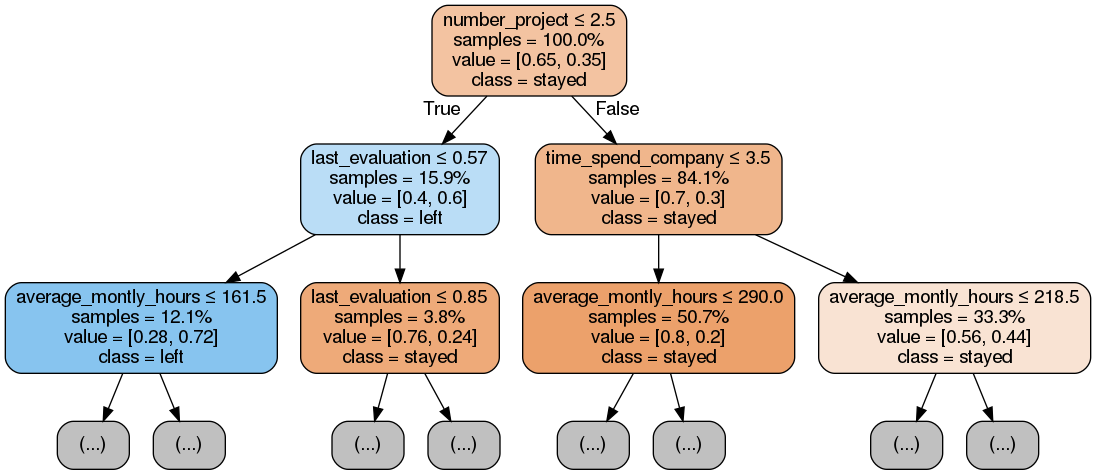

In [5]:
class_names = ['stayed', 'left']

def plot_tree(model, out_file, max_depth):

    dot_data = tree.export_graphviz(decision_tree=model, out_file=out_file,
                                    max_depth=max_depth,
                                    feature_names=features,
                                    class_names=class_names,
                                    filled=True, rounded=True,  
                                    special_characters=True,
                                    proportion = True, precision=2,
                                    label='all', impurity=False,
                                   )  

    graph = pydotplus.graphviz.graph_from_dot_file(out_file)  
    return Image(graph.create_png())
    
plot_tree(model, out_file="small_tree.out", max_depth=2)

## Оценим качество

In [6]:
train_data, test_data, train_target, test_target = (
    train_test_split(data[features], data[target], test_size = 0.5, random_state=0))

In [7]:
model.fit(train_data, train_target)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [8]:
train_predictions = model.predict(train_data)
print(accuracy_score(train_target, train_predictions))

0.9541272169622617


In [9]:
test_predictions = model.predict(test_data)
print(accuracy_score(test_target, test_predictions))

0.6596


## Исследуем "устойчивость" модели

In [10]:
import random

In [11]:
def plot_noised_tree(noise_size):
    random_gen = random.Random(42)
    model.fit(
        train_data, 
        [
            random_gen.randint(0, 1) 
            for _ in range(noise_size)
        ] + list(train_target[noise_size:])
    )
    return plot_tree(model, "first_tree.out", max_depth=3)

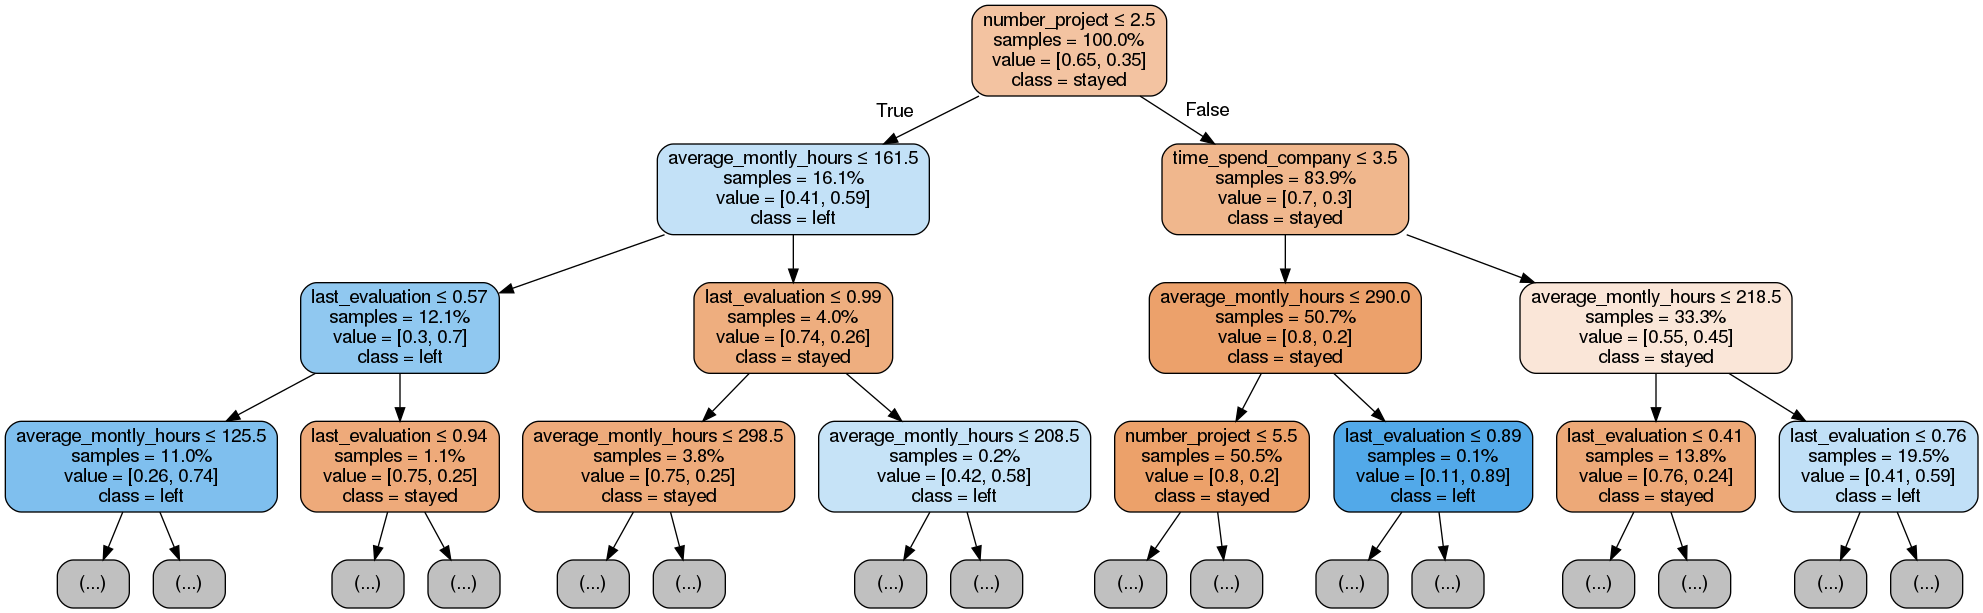

In [12]:
plot_noised_tree(0)

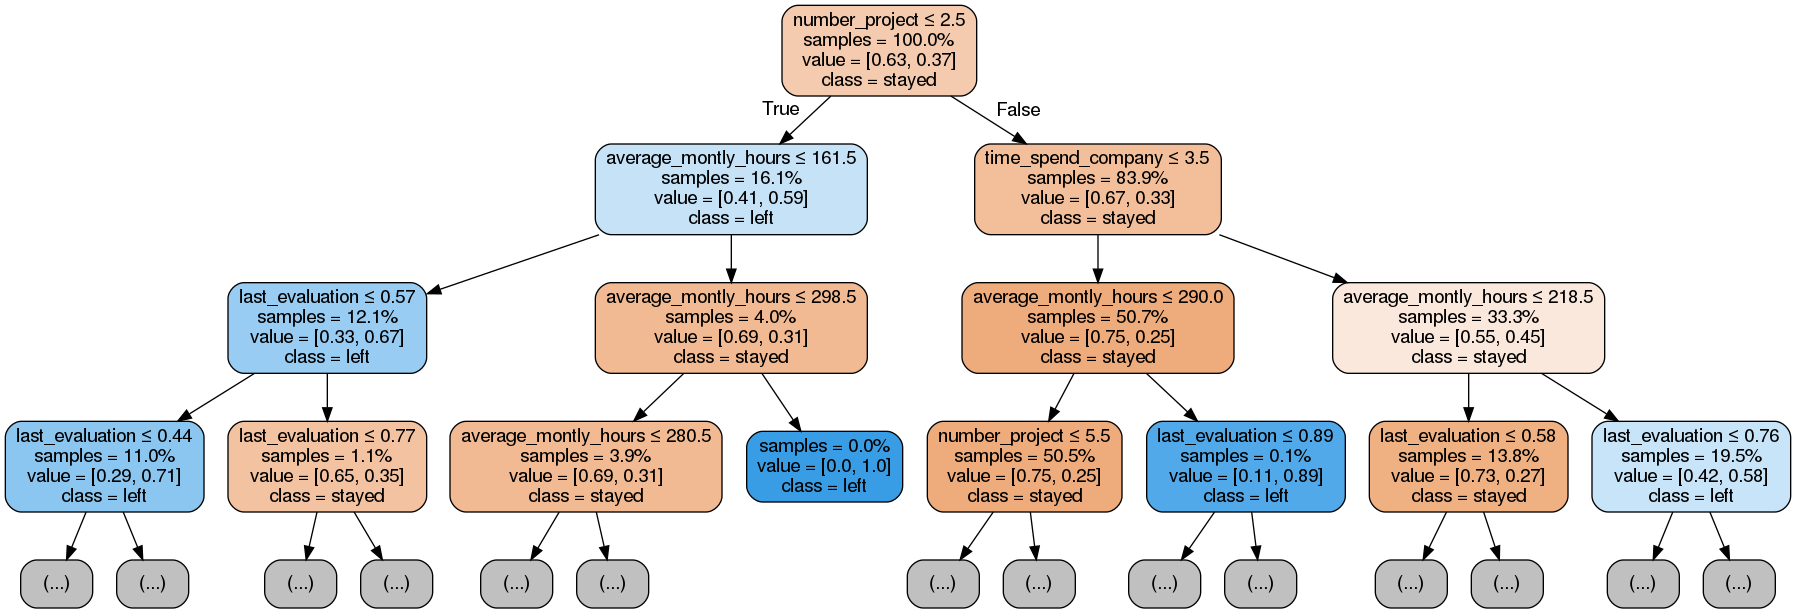

In [13]:
plot_noised_tree(1000)

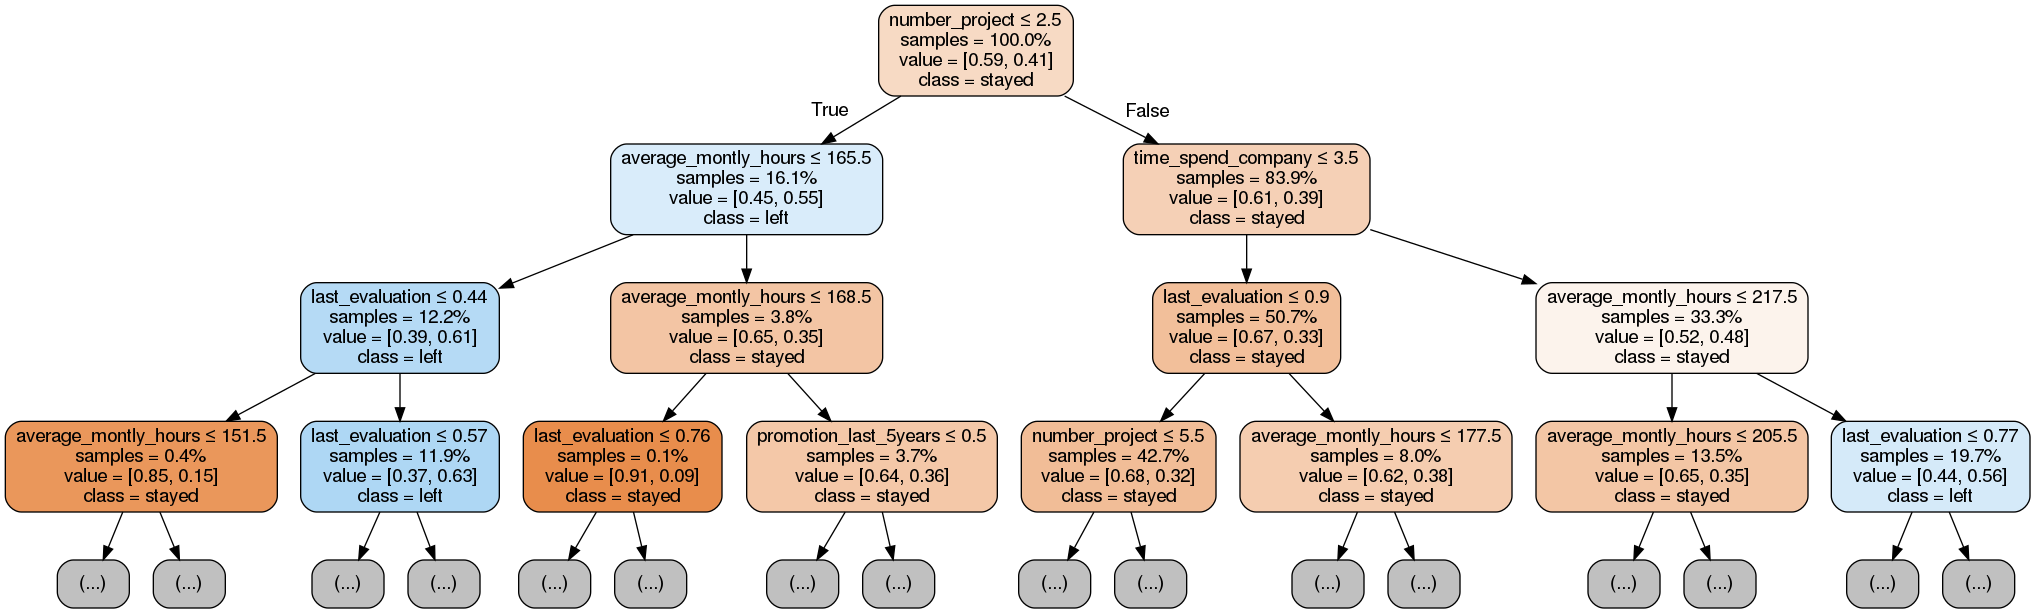

In [14]:
plot_noised_tree(3000)

In [15]:
def plot_sampled_tree(seed):
    random_gen = np.random.RandomState(seed)
    indices = random_gen.choice(len(train_data), size=len(train_data), replace=True)
    model.fit(
        np.array(train_data)[indices], 
        np.array(train_target)[indices]
    )
    return plot_tree(model, "first_tree.out", max_depth=3)

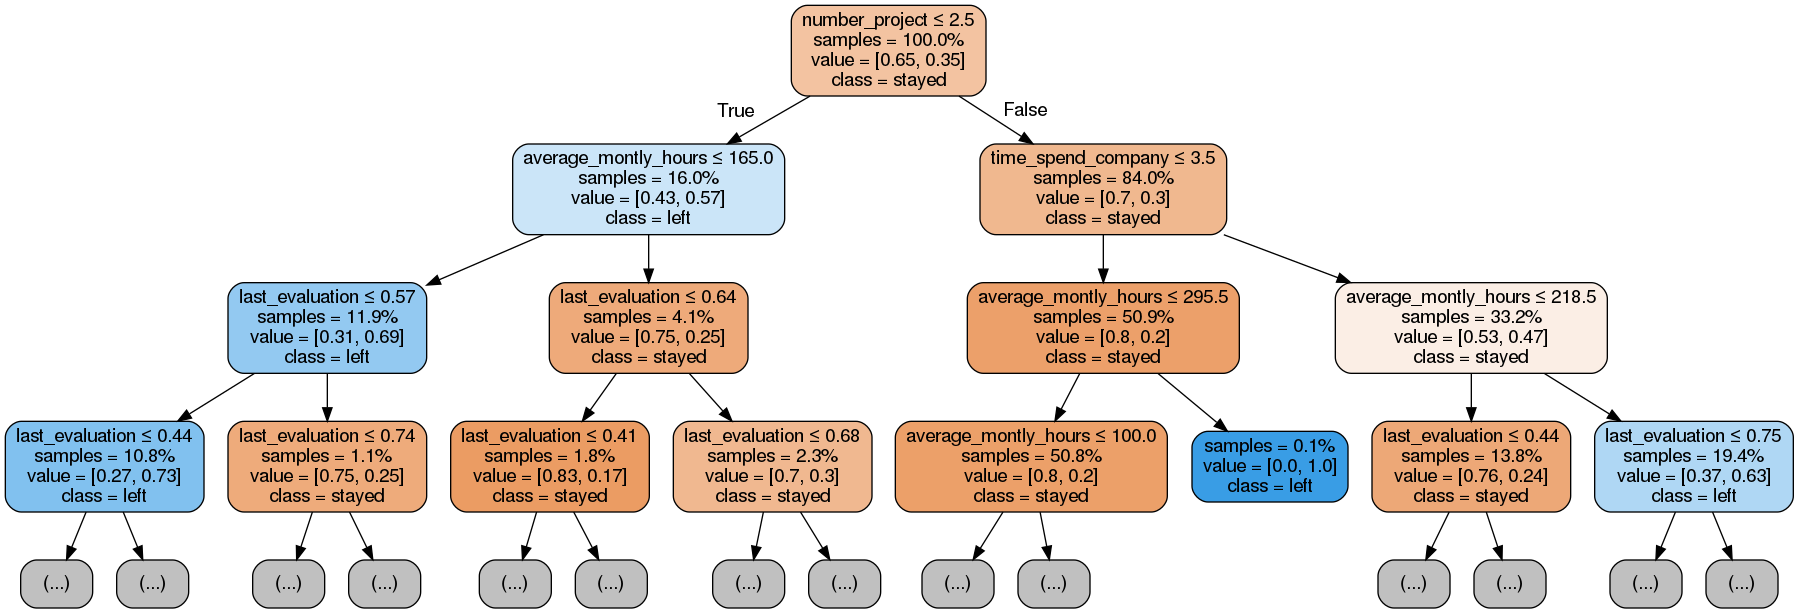

In [16]:
plot_sampled_tree(42)

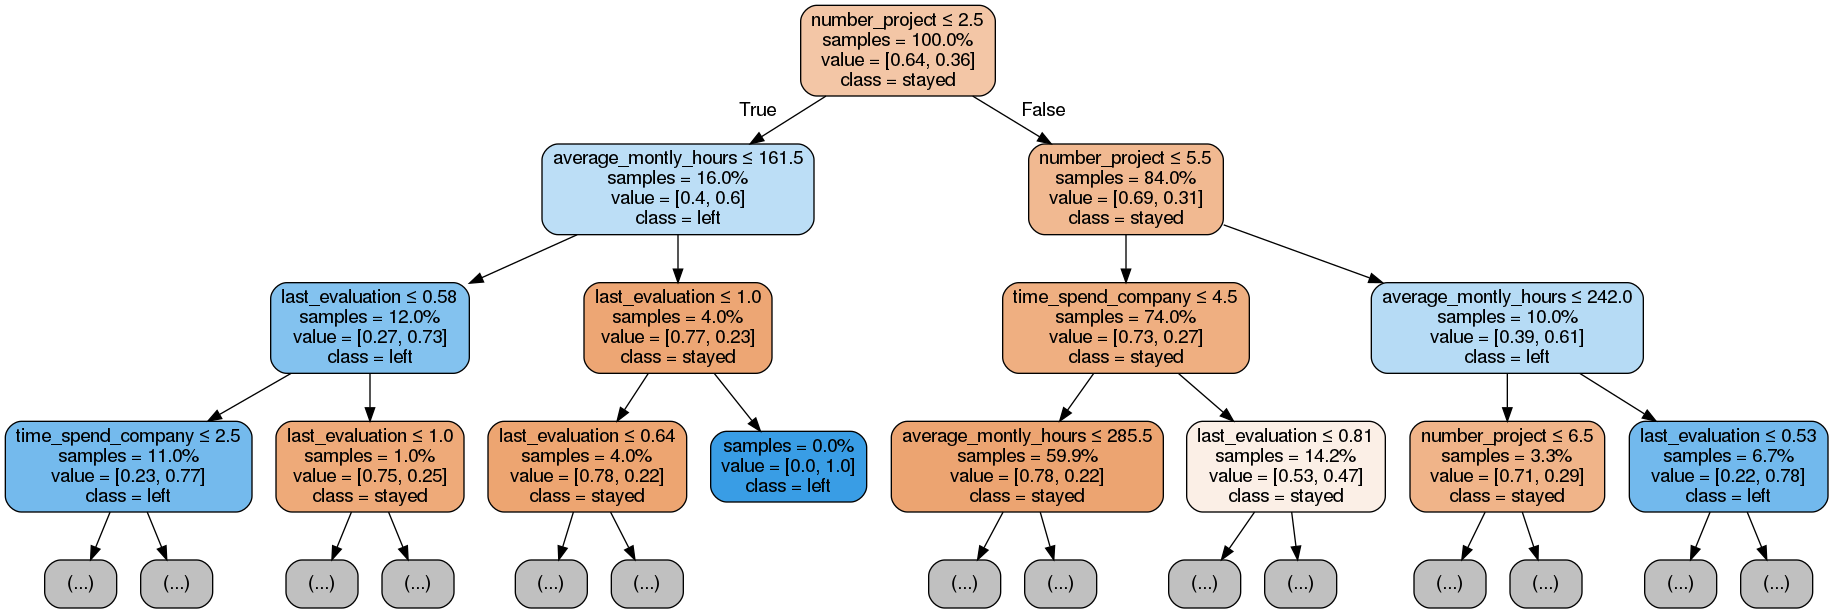

In [17]:
plot_sampled_tree(777)

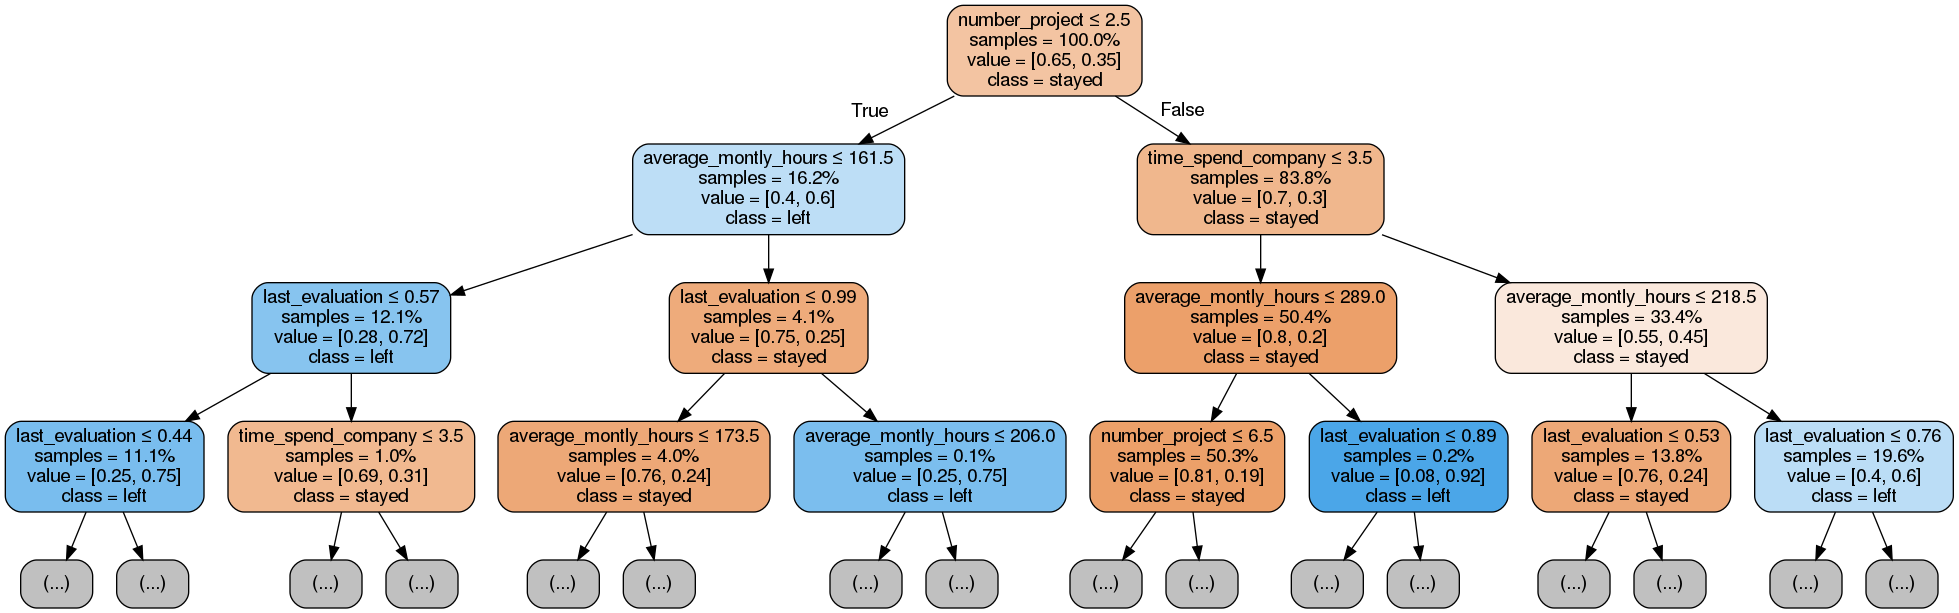

In [18]:
plot_sampled_tree(666)

# Извлечение признаков, выделяемых деревьями

In [20]:
X, y = data[features], data[target]

In [21]:
from sklearn.tree import _tree

def tree_to_code(tree, feature_names, return_class=True):
        
    '''
    Outputs a decision tree model as a Python function
    
    Parameters:
    -----------
    tree: decision tree model
        The decision tree to represent as a function
    feature_names: list
        The feature names of the dataset used for building the decision tree
    return class:
        Return most frequent class rather than number of elements of each class in the node
    '''

    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "    " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else:".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            value = tree_.value[node][0]
            if return_class and len(value) > 1:
                value = np.argmax(tree_.value[node])

            print("{}return {}".format(indent, value))

    recurse(0, 1)

In [22]:
data_sample = data.sample(200)
model = tree.DecisionTreeClassifier(max_depth=2)
model.fit(data_sample[features], data_sample[target])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [23]:
tree_to_code(model, features)

def tree(last_evaluation, number_project, average_montly_hours, time_spend_company, Work_accident, promotion_last_5years):
    if average_montly_hours <= 273.5:
        if number_project <= 2.5:
            return 1
        else:
            return 0
    else:
        if time_spend_company <= 2.5:
            return 0
        else:
            return 1


In [24]:
print('Logistic Regression with base features:', cross_val_score(LogisticRegression(), data[features], data[target]).mean())

Logistic Regression with base features: 0.6287053143962126


In [37]:
data['new_feature_01'] = (data.number_project <= 2.5) & (data.last_evaluation < 0.53)
data['new_feature_02'] = (data.number_project <= 4.5) & (data.last_evaluation < 0.58)

In [38]:
data[['number_project', 'last_evaluation', 'new_feature_01', 'new_feature_02']].head()

,number_project,last_evaluation,new_feature_01,new_feature_02
0,2,0.53,False,True
1,5,0.86,False,False
2,7,0.88,False,False
3,5,0.87,False,False
4,2,0.52,True,True


In [39]:
new_features = [c for c in data if c != target]
print('Logistic Regression with new features:', cross_val_score(LogisticRegression(), data[new_features], data[target]).mean())

Logistic Regression with new features: 0.6856465293058611
